
# Battery project



## Day 2 - Li intercalation energy



Today we will calculate the energy cost/gain associated with intercalating a lithium atom into graphite using approaches at different levels of theory. After today you should be able to:

- Setup structures and do relaxations using ASE and GPAW.
- Discuss which level of theory is required to predict the Li intercalation energy and why?

The Li intercalation reaction is:
$$Li(s) + C_x^{graphite} \rightarrow LiC_x$$
and the intercalation energy will then be
$$E_{Li@graphite} = E_{LiC_x} - (E_{Li(s)} + E_{C_x^{graphite}})$$
Where $x$ is the number of Carbon atoms in your computational cell.

We will calculate these energies using Density Functional Theory (DFT) with different exchange-correlation functionals. Graphite is characterised by graphene layers with strongly bound carbon atoms in hexagonal rings and weak long-range van der Waals interactions between the layers.

In the sections below we will calculate the lowest energy structures of each compound. This is needed to determine the intercalation energy.

- [Graphite](#graphite)
- [Li metal](#limetal)
- [Li intercalation](#liintercalation)





<a id='graphite'></a>
## Graphite



![graphite](C64.png)



To try some of the methods that we are going to use we will start out by utilizing the interatomic potential [EMT](https://wiki.fysik.dtu.dk/ase/ase/calculators/emt.html) (Effective Medium Theory) calculator. This will allow to quickly test some of the optimization procedures in ASE, and ensure that the scripts do what they are supposed to, before we move on to the more precise and time consuming DFT calculations. Initially we will calculate the C-C distance and interlayer spacing in graphite in a two step procedure.


In [3]:
# The graphite structure is set up using a tool in ASE
from ase.lattice.hexagonal import Graphite

# One has only to provide the lattice constants
structure = Graphite('C', latticeconstant={'a': 1.5, 'c': 4.0})


To verify that the structures is as expected we can check it visually.


In [2]:
from ase.visualize import view

view(structure)  # This will pop up the ase gui window


Next we will use the EMT calculator to get the energy of graphite. Remember absolute energies are not meaningful, we will only use energy differences.


In [3]:
from ase.calculators.emt import EMT

calc = EMT()
structure.calc = calc
energy = structure.get_potential_energy()
print(f'Energy of graphite: {energy:.2f} eV')


Energy of graphite: 15.84 eV



The cell below requires some input. We set up a loop that should calculate the energy of graphite for a series of C-C distances.


In [4]:
import numpy as np

# Provide some initial guesses on the distances
ccdist = 1.3
layerdist = 3.7

# We will explore distances around the initial guess
dists = np.linspace(ccdist * .8, ccdist * 1.2, 10)
# The resulting energies are put in the following list
energies = []
for cc in dists:
    # Calculate the lattice parameters a and c from the C-C distance
    # and interlayer distance, respectively
    a = cc * np.sqrt(3)
    c = 2 * layerdist

    gra = Graphite('C', latticeconstant={'a': a, 'c': c})

    # Set the calculator and attach it to the Atoms object with
    # the graphite structure
    calc = EMT()
    gra.calc = calc

    energy = gra.get_potential_energy()
    # Append results to the list
    energies.append(energy)



Determine the equilibrium lattice constant. We use a [np.polynomial.Polynomial](https://www.numpy.org/devdocs/reference/generated/numpy.polynomial.polynomial.Polynomial.html#numpy.polynomial.polynomial.Polynomial)


<IPython.core.display.Javascript object>


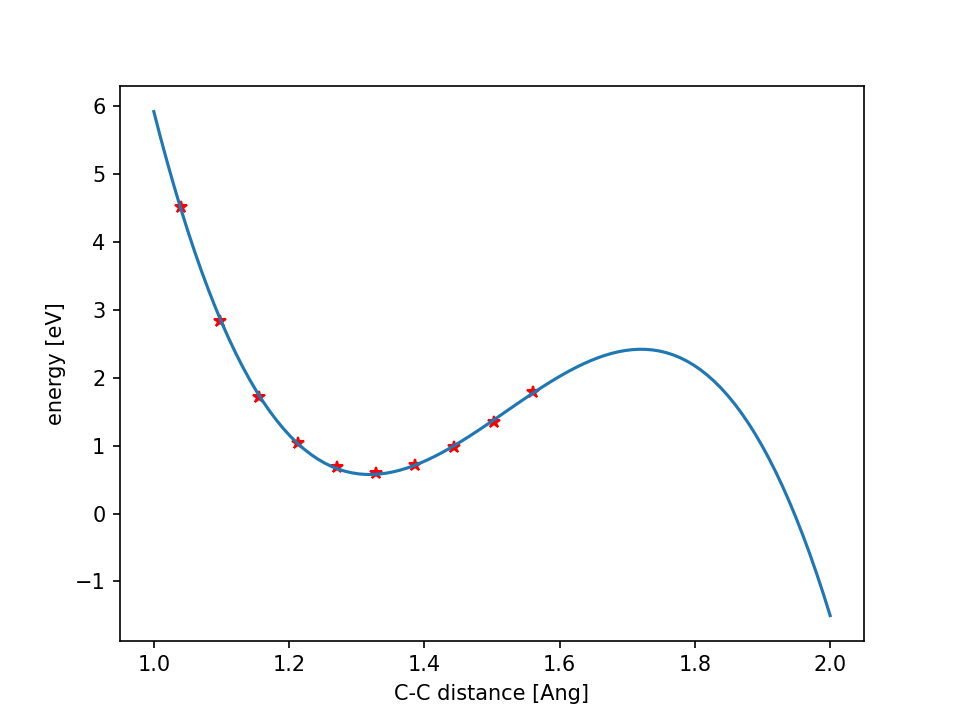

Text(0, 0.5, 'energy [eV]')

In [5]:
# Fit a polynomial:
poly = np.polynomial.Polynomial.fit(dists, energies, 3)
# and plot it:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(dists, energies, '*r')
x = np.linspace(1, 2, 100)
ax.plot(x, poly(x))
ax.set_xlabel('C-C distance [Ang]')
ax.set_ylabel('energy [eV]')

In [6]:
poly1 = poly.deriv()
poly1.roots()  # two extrema

array([1.31905785, 1.72059097])

In [7]:
# Find the minimum:
emin, ccdist = min((poly(d), d) for d in poly1.roots())
ccdist

1.3190578510190314

In [10]:
[(poly(d), d) for d in poly1.roots()]

[(0.5748928066014829, 1.3190578510190314),
 (2.4205421227027735, 1.7205909702315072)]

In [11]:
# alternatively:
poly2 = poly1.deriv()
for ccdist in poly1.roots():
    if poly2(ccdist) > 0:
        break
ccdist

1.3190578510190314


Make a script that calculates the interlayer distance with EMT in the cell below


In [7]:
# This script will calculate the energy of graphite for a series of inter-layer distances.
from ase.calculators.emt import EMT
from ase.lattice.hexagonal import Graphite
from ase.eos import EquationOfState
import numpy as np

# ccdist is already defined in the previous cell
# Start from a small guess
layerdist = 2.0

# Teacher
dists = np.linspace(layerdist * .8, layerdist * 1.2, 10)
# The resulting energies are put in the following list
energies = []
for ld in dists:
    # Calculate the lattice parameters a and c from the C-C distance
    # and interlayer distance, respectively
    a = ccdist * np.sqrt(3)
    c = 2 * ld

    gra = Graphite('C', latticeconstant={'a': a, 'c': c})

    # Set the calculator and attach it to the Atoms object with
    # the graphite structure
    calc = EMT()
    gra.calc = calc

    energy = gra.get_potential_energy()
    # Append results to the list
    energies.append(energy)

poly = np.polynomial.Polynomial.fit(dists, energies, 3)
layerdist = next (d for d in poly.deriv().roots() if poly.deriv(2)(d) > 0)
print(layerdist)



1.4557654202688564



Now both the optimal C-C distance and the interlayer distance is evaluated with EMT. Try to compare with the experimental numbers provided below.

|                         | Experimental values | EMT | LDA | PBE | PBE+DFTD3 |
|-------------------------|---------------------|-----|-----|-----|-----------|
| C-C  distance / Å       |               1.420 |     |     |     |           |
| Interlayer distance / Å |                3.35 |     |     |     |           |




Not surprisingly we need to use more sophisticated theory to model this issue. Below we will use DFT as implemented in GPAW to determine the same parameters.



First we set up an initial guess of the structure as before.


In [13]:
import numpy as np
from ase.lattice.hexagonal import Graphite

ccdist = 1.40
layerdist = 3.33
a = ccdist * np.sqrt(3)
c = 2 * layerdist
gra = Graphite('C', latticeconstant={'a': a, 'c': c})



Then we create the GPAW calculator object. The parameters are explained [here](https://wiki.fysik.dtu.dk/gpaw/documentation/manual.html#parameters), see especially the section regarding [mode](https://wiki.fysik.dtu.dk/gpaw/documentation/manual.html#manual-mode). This graphite structure has a small unit cell, thus plane wave mode, `mode=PW()`, will be faster than the grid mode, `mode='fd'`. Plane wave mode also lets us calculate the strain on the unit cell - useful for optimizing the lattice parameters.

We will start by using the LDA exchange-correlation functional. Later you will try other functionals.


In [14]:
from gpaw import GPAW, PW

xc = 'LDA'
calcname = f'graphite-{xc}'
calc = GPAW(mode=PW(500), kpts=(10, 10, 6), xc=xc,
            txt=calcname + '.log')

gra.calc = calc  # Connect system and calculator
print(gra.get_potential_energy())


-40.44691398135785



Check out the contents of the output file, all relevant information about the scf cycle are printed therein:


In [15]:
n = calcname + '.log'
!cat $n


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  22.1.1b1
 |___|_|             

User:   dft22x019@n-62-27-19
Date:   Sun Aug 14 16:33:19 2022
Arch:   x86_64
Pid:    14740
CWD:    /zhome/fa/5/1000203270/CAMD2022/batteries
Python: 3.8.5
gpaw:   /zhome/fa/5/1000203270/CAMD2022/venv/gpaw/gpaw (4191706c58)
_gpaw:  /zhome/fa/5/1000203270/CAMD2022/venv/gpaw/
        _gpaw.cpython-38-x86_64-linux-gnu.so (88bf7688a8)
ase:    /zhome/fa/5/1000203270/CAMD2022/venv/ase/ase (version 3.23.0b1-bcce2b6c57)
numpy:  /zhome/fa/5/1000203270/CAMD2022/venv/lib/python3.8/site-packages/numpy (version 1.22.4)
scipy:  /zhome/fa/5/1000203270/CAMD2022/venv/lib/python3.8/site-packages/scipy (version 1.8.1)
libxc:  4.3.4
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  kpts: [10 10  6]
  mode: {ecut: 500.0,
         name: pw}

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

species:
  C:
 


Then we optimize the unit cell of the structure. We will take advantage of the [StrainFilter](https://wiki.fysik.dtu.dk/ase/ase/constraints.html#the-strainfilter-class) class. This allows us to simultaneously optimize both C-C distance and interlayer distance. We employ the [BFGS](http://aria42.com/blog/2014/12/understanding-lbfgs) algorithm to minimize the strain on the unit cell.


In [16]:
from ase.constraints import StrainFilter
from ase.optimize.bfgs import BFGS
from ase.io import Trajectory

sf = StrainFilter(gra, mask=[1, 1, 1, 0, 0, 0])
opt = BFGS(sf, trajectory=calcname + '.traj')
# traj = Trajectory(calcname + '.traj', 'w', gra)
# opt.attach(traj)
opt.run(fmax=0.01)


      Step     Time          Energy          fmax
BFGS:    0 16:34:37      -40.446914         3.178540
BFGS:    1 16:35:17      -40.329432         8.990816
BFGS:    2 16:35:55      -40.469238         0.336562
BFGS:    3 16:36:34      -40.468859         0.218799
BFGS:    4 16:37:17      -40.466650         0.404585
BFGS:    5 16:37:57      -40.464845         0.248841
BFGS:    6 16:38:37      -40.465119         0.046625
BFGS:    7 16:39:19      -40.465411         0.002539


True


Read in the result of the relaxation and determine the C-C and interlayer distances.


In [17]:
from ase.io import read
import numpy as np

atoms = read(calcname + '.traj')
a = atoms.cell[0, 0]
h = atoms.cell[2, 2]
# Determine the rest from here
print(a / np.sqrt(3))
print(h / 2)

1.410804903050403
3.2157366138826924



Now we need to try a GGA type functional (e.g. PBE) and also try to add van der Waals forces on top of PBE (i.e. PBE+DFTD3). These functionals will require more computational time, thus the following might be beneficial to read.



If the relaxation takes too long time, we can submit it to be run in parallel on the computer cluster. Remember we can then run different calculations simultaneously. There are two ways to achieve this:

A. Log in to the gbar terminal, save a full script in a file (e.g. `calc.py`) and submit that file to be calculated in parallel (e.g. `mq submit calc.py -R 8:5h` (5 hours on 8 cores)).

or

B. Stay in the notebook and submit the calculations using some commands we will give you, these are explained in the following cells.



You need to make a full working script in a cell that does not depend on variables defined in any other cells. Do that in the cell below. Once you are done, run it for a few seconds to make sure there is no error, then stop it by `interrupt the kernel`. This will give you an error message, ignore that and move on, we will submit the calculation in the next cell.


In [2]:
%%writefile graphite_LDA.py

# Full script
# from ase...

# Teacher
import numpy as np
from ase.lattice.hexagonal import Graphite
from ase.calculators.dftd3 import DFTD3
from ase.constraints import StrainFilter
from ase.optimize.bfgs import BFGS
from ase.io import Trajectory

ccdist = 1.41
layerdist = 3.21
a = ccdist * np.sqrt(3)
c = 2 * layerdist
gra = Graphite('C', latticeconstant={'a': a, 'c': c})

from gpaw import GPAW, PW

for xc in ['LDA', 'PBE', 'DFTD3']:
    if xc == 'DFTD3':
        dft = GPAW(mode=PW(500), kpts=(10, 10, 6), xc='PBE',
                   txt=f'graphite-{xc}.log')
        calc = DFTD3(dft=dft, xc='PBE')
    else:
        calc = GPAW(mode=PW(500), kpts=(10, 10, 6), xc=xc,
                    txt=f'graphite-{xc}.log')

    gra.calc = calc  # Connect system and calculator

    sf = StrainFilter(gra, mask=[1, 1, 1, 0, 0, 0])
    opt = BFGS(sf, trajectory=f'graphite-{xc}.traj')
    # traj = Trajectory(f'graphite-{xc}.traj', 'w', gra)
    # opt.attach(traj)
    opt.run(fmax=0.01)

Writing graphite_LDA.py



The following cell submits a calculation using [`myqueue`](https://myqueue.readthedocs.io/en/latest/).

Note the line `#%%writefile graphite_LDA.py` in the previous cell.  Remove the `#` symbol and execute the cell again.  This will write the cell to a file that you can use submit to the queue:


In [3]:
!mq submit graphite_LDA.py -R 8:1h  # submits the calculation to 8 cores, 1 hour


13907896 ./ graphite_LDA.py 8:1h
1 task submitted



Check the status of the calculation by running the cell below. The column with `S` heading gives you a character code of the status: `Q`: still in queue, `R`: running, `C`: finished.


In [14]:
!mq ls


id       folder name               res.        age state  time error
-------- ------ ------------------ ---- ---------- ------ ---- -----------------
13907623 ./     lifepo4.py         8:1h 1:02:48:53 done   3:58 
13907896 ./     graphite_LDA.py    8:1h 1:02:05:50 done   2:11 
13908847 ./     intercalation_e.py 8:1h    7:12:39 FAILED 4:41 [n-62-28-28:30527
13908851 ./     fepo4.py           8:1h    7:10:08 done   4:05 
13908963 ./     intercalation_e.py 8:1h    6:04:13 FAILED 4:24 [n-62-28-34:28660
13909236 ./     fepo4.py           8:1h    5:13:47 done   3:52 
13909295 ./     fepo4.py           8:1h    4:58:46 done   4:06 
13909311 ./     lifepo4.py         8:1h    4:52:01 done   4:05 
13909569 ./     NEB.py             8:1h    4:02:55 FAILED 0:02 -----------------
13910065 ./     fepo4_1li.py       8:1h    2:00:56 FAILED 0:02 NameError: name '
13910190 ./     fepo4_1li.py       8:1h    1:05:58 FAILED 0:02 NameError: name '
13910241 ./     fepo4_1li_sub.py   8:1h      18:46 FAILED 0:0


When the calculation finishes the result can be interpreted by [reading](https://wiki.fysik.dtu.dk/ase/ase/io/io.html#ase.io.read) in the Atoms object. This assumes that the trajectory file is called: `graphite-LDA.traj`, if not change accordingly.


In [2]:
from ase.io import read

# The full relaxation
relaxation = read('graphite-LDA.traj', index=':')
# The final image of the relaxation containing the relevant energy
atoms = read('graphite-LDA.traj')

In [3]:
# Extract the relevant information from the calculation

# Energy
print(atoms.get_potential_energy())

# Unit cell
print(atoms.get_cell())

# See the steps of the optimization
from ase.visualize import view
view(relaxation)

-40.46499566978582
Cell([[2.443587370617134, 0.0, 0.0], [-1.2217936853085665, 2.116208739321258, 0.0], [0.0, 0.0, 6.421856137089127]])



<a id='limetal'></a>
## Li metal



![Li metal](Li2.png)

Now we need to calculate the energy of Li metal. We will use the same strategy as for graphite, i.e. first determine the lattice constant, then use the energy of that structure. This time though you will have to do most of the work.

Some hints:
1. The crystal structure of Li metal is shown in the image above. That structure is easily created with one of the functions in the [ase.build](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) module
2. A k-point density of approximately 2.4 points / Angstrom will be sufficient
3. The DFTD3 correction is done _a posteriori_, this means the calculator should be created a little differently, see [the second example here](https://wiki.fysik.dtu.dk/ase/ase/calculators/dftd3.html#examples)
4. See also the [equation of state module](https://wiki.fysik.dtu.dk/ase/ase/eos.html)

In the end try to compare the different functionals with experimental values:

|       | Experimental values | LDA | PBE | PBE+DFTD3 |
|-------|---------------------|-----|-----|-----------|
| a / Å |                3.51 |     |     |           |




In [4]:
# Teacher

from ase import Atoms
from gpaw import GPAW, FermiDirac, PW
from ase.optimize import QuasiNewton
from ase.build import bulk
from ase.calculators.dftd3 import DFTD3
from ase.constraints import StrainFilter
from ase.optimize.bfgs import BFGS

# This script will optimize lattice constant of metallic lithium
for xc in ['LDA', 'PBE', 'DFTD3']:
    Li_metal = bulk('Li', crystalstructure='bcc', a=3.3)

    if xc == 'DFTD3':
        dft = GPAW(mode=PW(500),
                   kpts=(8, 8, 8),
                   nbands=-10,
                   txt=f'Li-metal-{xc}.log',
                   xc='PBE')
        calc = DFTD3(dft=dft, xc='PBE')
    else:
        calc = GPAW(mode=PW(500),
                    kpts=(8, 8, 8),
                    nbands=-10,
                    txt=f'Li-metal-{xc}.log',
                    xc=xc)

    Li_metal.calc = calc

    sf = StrainFilter(Li_metal, mask=[1, 1, 1, 0, 0, 0])
    opt = BFGS(sf, trajectory=f'Li-metal-{xc}.traj')
    opt.run(fmax=0.01)



      Step     Time          Energy          fmax
BFGS:    0 11:12:00       -2.047707         0.183917
BFGS:    1 11:12:04       -2.048154         0.168576
BFGS:    2 11:12:10       -2.050448         0.007285
      Step     Time          Energy          fmax
BFGS:    0 11:12:18       -1.904985         0.384492
BFGS:    1 11:12:24       -1.906964         0.350271
BFGS:    2 11:12:32       -1.916862         0.029788
BFGS:    3 11:12:40       -1.916905         0.002554
      Step     Time          Energy          fmax
BFGS:    0 11:12:47       -2.017675         0.165103
BFGS:    1 11:12:54       -2.018034         0.152539
BFGS:    2 11:13:00       -2.020081         0.007143



Get the lattice information and compare with experimental values


In [5]:
a = Li_metal.get_cell()[0][0]  



<a id='liintercalation'></a>
## Li intercalation in graphite



![Li intercalated in graphite](C144Li18.png)

Now we will calculate the intercalation of Li in graphite. For simplicity we will represent the graphite with only one layer. Also try and compare the C-C and interlayer distances to experimental values.

|                         | Experimental values | LDA | PBE | PBE+DFTD3 |
|-------------------------|---------------------|-----|-----|-----------|
| C-C distance / Å        |               1.441 |     |     |           |
| Interlayer distance / Å |               3.706 |     |     |           |



In [8]:
# A little help to get you started with the combined structure
from ase.lattice.hexagonal import Graphene
from ase import Atom
import numpy as np

# We will have to optimize these distances
ccdist = 1.40
layerdist = 3.7

a = ccdist * np.sqrt(3)
c = layerdist

# We will require a larger cell, to accomodate the Li
Li_gra = Graphene('C', size=(2, 2, 1), latticeconstant={'a': a, 'c': c})
# Append an Li atom on top of the graphene layer
Li_gra.append(Atom('Li', (a / 2, ccdist / 2, layerdist / 2)))


In [2]:
%%writefile intercalation_e.py
# Teacher

from gpaw import GPAW, PW
from ase import Atom
from ase.optimize.bfgs import BFGS
import numpy as np
from ase.lattice.hexagonal import Graphene
from ase.constraints import StrainFilter

for xc in ['LDA', 'PBE', 'DFTD3']:
    ccdist = 1.40
    layerdist = 3.7

    a = ccdist * np.sqrt(3)
    c = layerdist

    calcname = f'Li-C8-{xc}'
    # We will require a larger cell, to accomodate the Li
    Li_gra = Graphene('C', size=(2, 2, 1), latticeconstant={'a': a, 'c': c})
    Li_gra.append(Atom('Li', (a / 2, ccdist / 2, layerdist / 2)))

    if xc == 'DFTD3':
        dft = GPAW(mode=PW(500), kpts=(5, 5, 6), xc='PBE', txt=calcname + '.log')
        calc = DFTD3(dft=dft, xc='PBE')
    else:
        calc = GPAW(mode=PW(500), kpts=(5, 5, 6), xc=xc, txt=calcname + '.log')

    Li_gra.calc = calc  # Connect system and calculator

    sf = StrainFilter(Li_gra, mask=[1, 1, 1, 0, 0, 0])
    opt = BFGS(sf, trajectory=calcname + '.traj')
    opt.run(fmax=0.01)
    


Writing intercalation_e.py


In [3]:
!mq submit intercalation_e.py -R 8:1h  # submits the calculation to 8 cores, 1 hour

13908963 ./ intercalation_e.py 8:1h
1 task submitted


In [7]:
!mq ls

id       folder name               res.      age state  time error
-------- ------ ------------------ ---- -------- ------ ---- -------------------
13907623 ./     lifepo4.py         8:1h 21:22:09 done   3:58 
13907896 ./     graphite_LDA.py    8:1h 20:39:06 done   2:11 
13908847 ./     intercalation_e.py 8:1h  1:45:55 FAILED 4:41 [n-62-28-28:30527] 
13908851 ./     fepo4.py           8:1h  1:43:24 done   4:05 
13908963 ./     intercalation_e.py 8:1h    37:30 FAILED 4:24 [n-62-28-34:28660] 
-------- ------ ------------------ ---- -------- ------ ---- -------------------
done: 3, FAILED: 2, total: 5



Now calculate the intercalation energy of Li in graphite with the following formula:
$$E_{Li@graphite} = E_{LiC_x} - (E_{Li(s)} + x * E_{C^{graphite}})$$
where $x$ is the number of Carbon atoms in your Li intercalated graphene cell. Remember to adjust the energies so that the correct number of atoms is taken into account.

These are the experimental values to compare with
In the end try to compare the different functionals with experimental values:

|                           | Experimental values | LDA | PBE | BEEF-vdW |
|---------------------------|---------------------|-----|-----|----------|
| Intercalation energy / eV |              -0.124 |     |     |          |




In [13]:
from ase.io import read
for xc in ['LDA', 'PBE', 'DFTD3']:
    Li_gra = read(f'Li-C8-{xc}.traj')
    Li_metal = read(f'Li-metal-{xc}.traj')
    gra = read(f'graphite-{xc}.traj')
    # Teacher
    e_Li_gra = Li_gra.get_potential_energy()
    e_Li = Li_metal.get_potential_energy() / len(Li_metal)
    e_C8 = 8 * gra.get_potential_energy() / len(gra)
    intercalation_energy = e_Li_gra - (e_Li + e_C8)
    print(f'{xc}-Intercalation energy: {intercalation_energy:.2f}eV')

LDA-Intercalation energy: -0.35eV
PBE-Intercalation energy: -0.06eV
DFTD3-Intercalation energy: -0.03eV


In [11]:
from ase.visualize import view
view(e)


Great job! When you have made it this far it is time to turn your attention to the cathode. If you have lots of time left though see if you can handle the bonus exercise.



## Bonus



In the calculation of the intercalated Li we used a graphene layer with 8 Carbon atoms per unit cell. We can actually use only 6 Carbon by rotating the x and y cell vectors. This structure will be faster to calculate and still have neglible Li-Li interaction.


In [ ]:
from ase import Atoms
from ase.visualize import view

ccdist = 1.40
layerdist = 3.7

a = ccdist * np.sqrt(3)
c = layerdist

Li_gra = Atoms('CCCCCCLi')  # Fill out the positions and cell vectors

# Teacher
for xc in ['LDA', 'PBE', 'DFTD3']:
    calcname = f'Li-C6-{xc}'
    Li_gra = Atoms('CCCCCCLi', positions=[(0, 0, 0), (0, ccdist, 0), (a, 0, 0),
                                          (-a, 0, 0), (-a / 2, -ccdist / 2, 0),
                                          (a / 2, -ccdist / 2, 0), (0, -ccdist, c / 2)],
                   cell=([1.5 * a, -1.5 * ccdist, 0],
                         [1.5 * a, 1.5 * ccdist, 0],
                         [0, 0, c]),
                   pbc=(1, 1, 1))

    if xc == 'DFTD3':
        dft = GPAW(mode=PW(500), kpts=(5, 5, 6), xc='PBE', txt=calcname + '.log')
        calc = DFTD3(dft=dft, xc='PBE')
    else:
        calc = GPAW(mode=PW(500), kpts=(5, 5, 6), xc=xc, txt=calcname + '.log')

    Li_gra.calc = calc  # Connect system and calculator

    sf = StrainFilter(Li_gra, mask=[1, 1, 1, 0, 0, 0])
    # traj = Trajectory(calcname + '.traj', 'w', Li_gra)
    opt = BFGS(sf, trajectory=calcname + '.traj')
    # opt.attach(traj)
    opt.run(fmax=0.01)